In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

## Read in data and bootstrap

In [2]:
# File with effective mass output.
base = 'output/'
cfg = 'cl3_16_48_b6p1_m0p2450_output5799'
file = base + cfg + '.txt'

In [3]:
f = open(file, 'r')

In [4]:
#randomly subsample a given number of configs
# subsample_size = 50
# sample_ids = np.random.choice(253, (subsample_size), replace = False)

In [5]:
# New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...
f.readline()
L3 = 48    #temporal extent of lattice
C = []
for i, line in enumerate(f):
    # if i not in sample_ids:
    #     continue
    cur_line = np.zeros(L3, dtype=complex)
    cfgIdx, rest = line.split('|')
    cfgIdx = int(cfgIdx)
    interps = rest.split(' ')    # now get real and complex
    for n_t, x in enumerate(interps):
        if not x.isspace():
            real, imag = x.split('+i(')    #form should be x = a+i(b)
            real = float(real)
            imag = float(imag.replace(')', ''))
            cur_line[n_t] = complex(real, imag)
    cur_line = [cur_line]
    if C == []:
        C = np.array(cur_line)
    else:
        C = np.append(C, cur_line, axis = 0)

/Users/theoares/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [6]:
def bootstrap(C, n_boot = 500):
    num_configs = C.shape[0]
    n_t = C.shape[1]
    samples = np.zeros((n_boot, num_configs, n_t), dtype = complex)
    for i in range(n_boot):
        cfgIds = np.random.choice(num_configs, num_configs)    #Configuration ids to pick
        samples[i, :, :] = C[cfgIds, :]
    return samples

In [7]:
num_configs = C.shape[0]
n_t = C.shape[1]
samples = bootstrap(C)
print(samples.shape)

(500, 253, 48)


## Compute correlation function and effective mass

In [8]:
# Compute ensemble average of each correlation function
ensemble_avg = np.mean(samples, axis = 1)
μ_C = np.abs(np.mean(ensemble_avg, axis = 0))
σ_C = np.abs(np.std(ensemble_avg, axis = 0))

In [9]:
# Compute effective mass
ratios = np.abs(ensemble_avg / np.roll(ensemble_avg, shift = -1, axis = 1))[:, :-1]
m_eff_ensemble = np.log(ratios)
μ_m_eff = np.mean(m_eff_ensemble, axis = 0)
σ_m_eff = np.std(m_eff_ensemble, axis = 0, ddof = 1)

In [10]:
# Compute cosh-corrected effective mass
N = 48
cosh_m_eff_ensemble = np.zeros(ratios.shape)
for ens_idx in range(ratios.shape[0]):
    for t in range(ratios.shape[1]):
        m = root(lambda m : ratios[ens_idx, t] - np.cosh(m * (t - N / 2)) / np.cosh(m * (t + 1 - N / 2)), \
                     m_eff_ensemble[ens_idx, t])
        cosh_m_eff_ensemble[ens_idx, t] = m.x
μ_cosh = np.mean(cosh_m_eff_ensemble, axis = 0)
σ_cosh = np.std(cosh_m_eff_ensemble, axis = 0, ddof = 1)

<IPython.core.display.Javascript object>


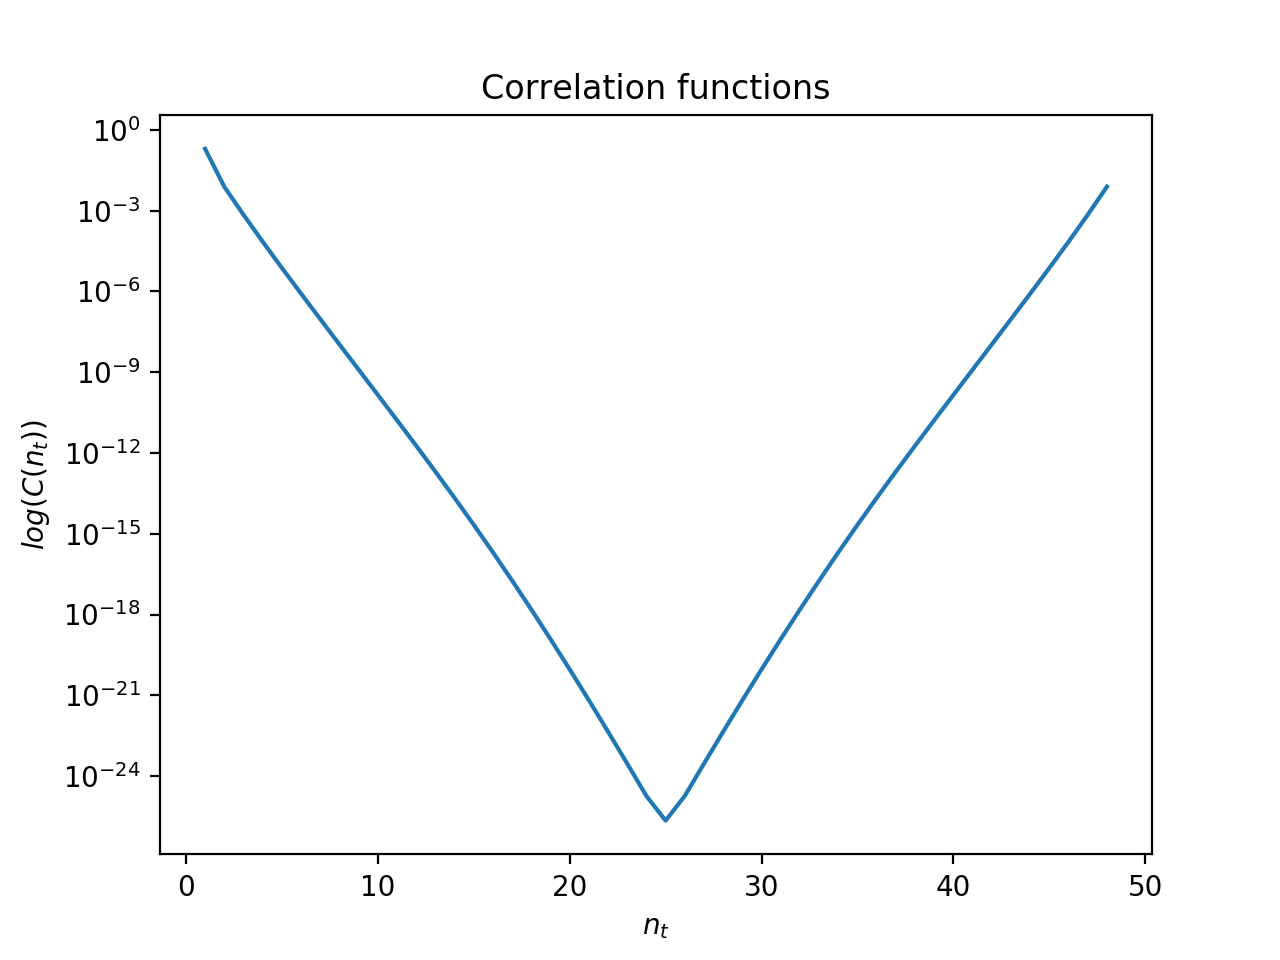

Text(0, 0.5, '$log(C(n_t))$')

In [11]:
plt.figure()
plt.errorbar(range(1, n_t + 1), μ_C, yerr = σ_C)
plt.yscale('log')
plt.title('Correlation functions')
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

<IPython.core.display.Javascript object>


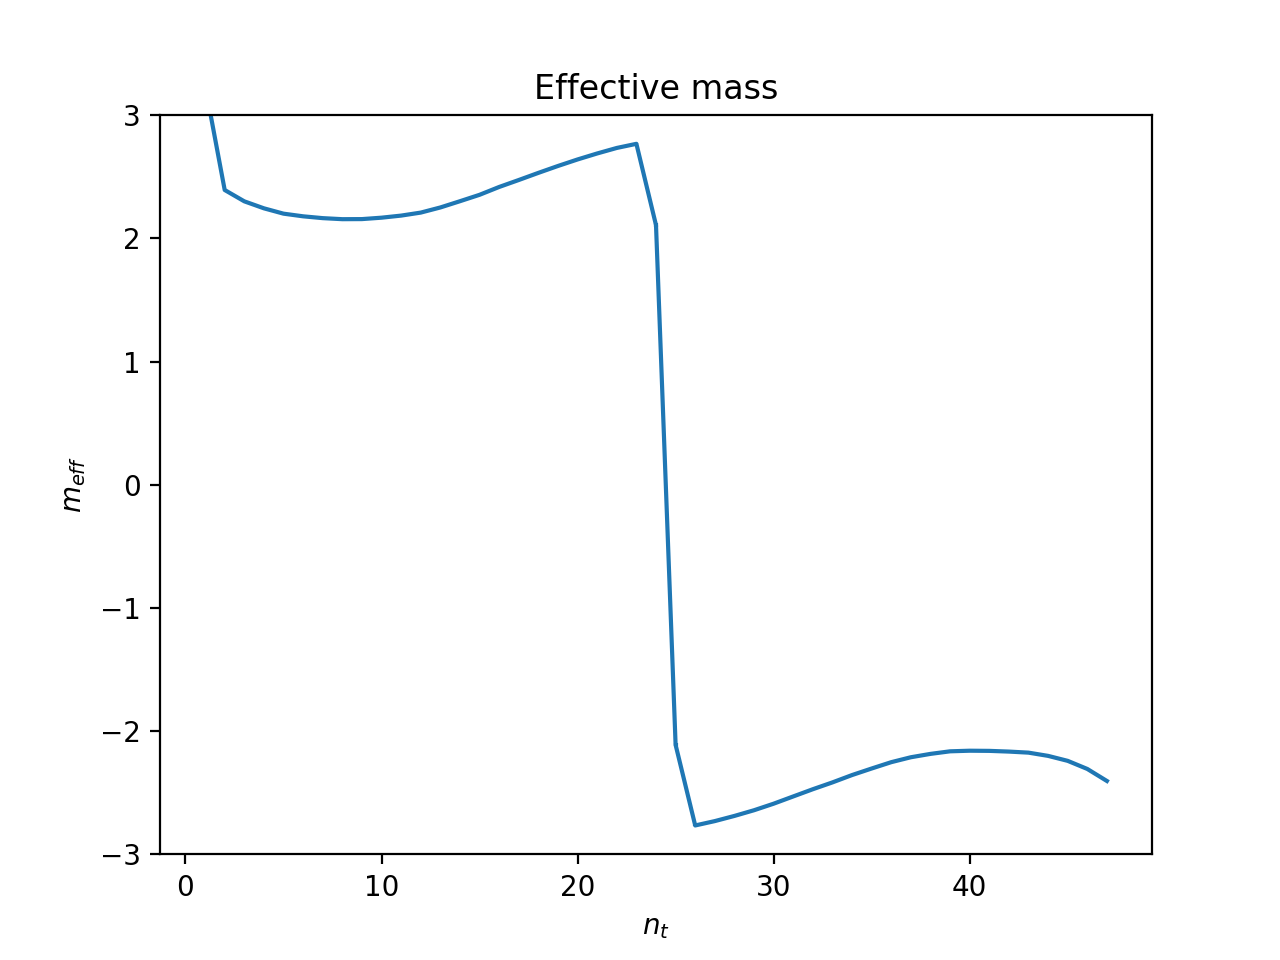

Text(0, 0.5, '$m_{eff}$')

In [12]:
plt.figure()
plt.errorbar(range(1, n_t), μ_m_eff, yerr = σ_m_eff)
plt.title('Effective mass')
plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')

<IPython.core.display.Javascript object>


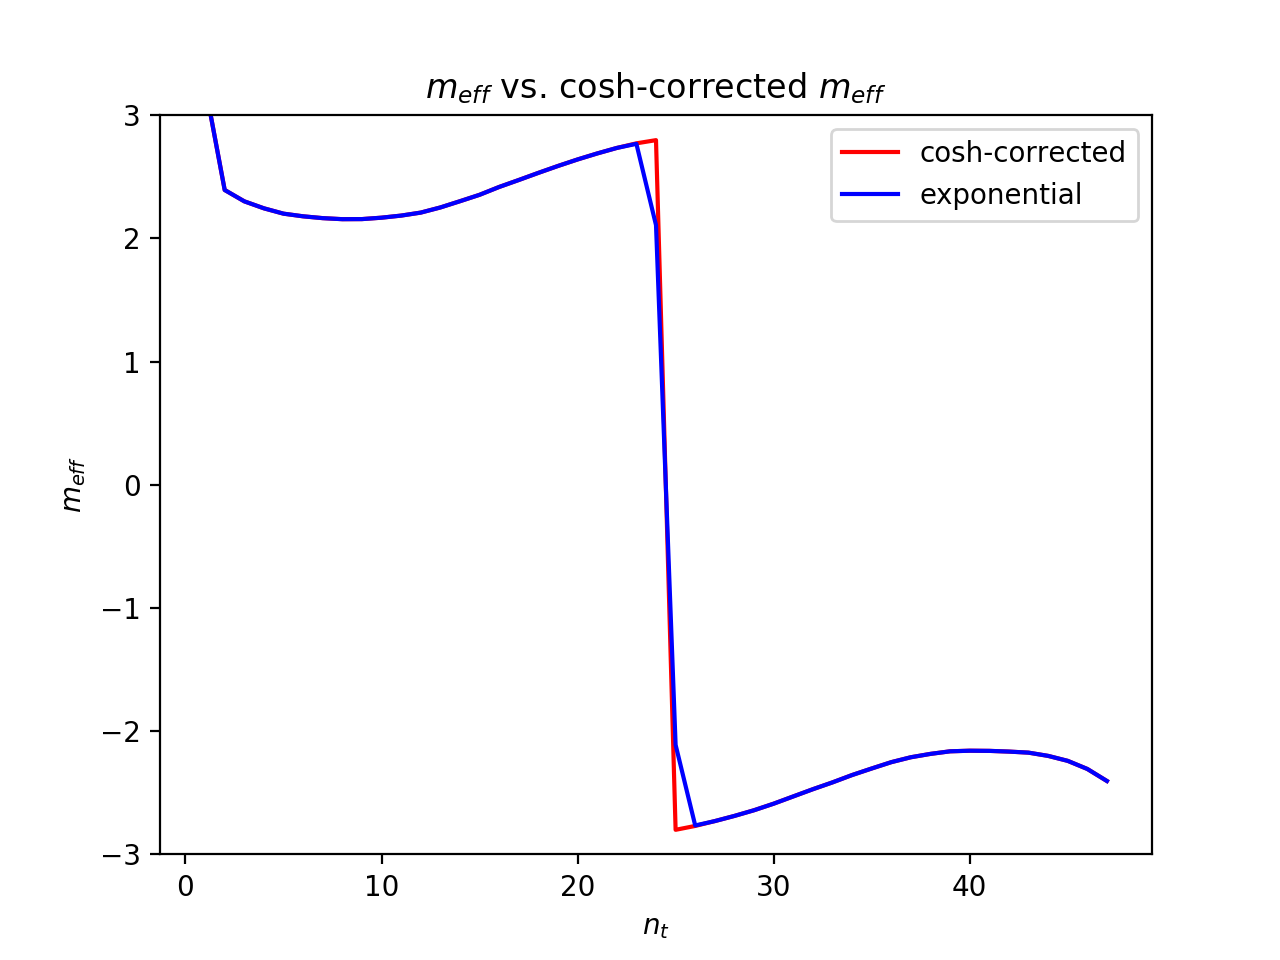

In [13]:
plt.figure()
plt.plot(range(1, n_t), μ_cosh, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_m_eff, 'b', label = 'exponential')

plt.title('$m_{eff}$ vs. cosh-corrected $m_{eff}$')
plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')
plt.legend()

plt.show()

In [14]:
# plt.savefig('/Users/theoares/lqcd/pion_mass/output/' + cfg + '.png')

## Determine error scaling

In [15]:
base_time = 15
cfg_list = range(10, num_configs, 10)
err = np.zeros(len(cfg_list))
means = np.zeros(len(cfg_list))
for i, n in enumerate(cfg_list):    # sample n configurations from C
    config_ids = np.random.choice(num_configs, n, replace = False)
    C_sub = C[config_ids, :]    #now get error on the subsampled C
    subensemble = bootstrap(C_sub)
    subensemble_avg = np.mean(subensemble, axis = 1)
    μ = np.abs(np.mean(subensemble_avg, axis = 0))
    σ = np.abs(np.std(subensemble_avg, axis = 0))
    err[i] = σ[base_time]
    means[i] = μ[base_time]

In [16]:
print('Errors are: ', err)
print('Average correlation function is: ', means)

Errors are:  [2.60917623e-17 1.31998671e-17 1.22974918e-17 1.05643486e-17
 1.12539072e-17 9.50463509e-18 8.84580434e-18 7.79238525e-18
 7.72050023e-18 7.61251152e-18 7.64479902e-18 6.68250211e-18
 6.69501183e-18 6.44658082e-18 6.70873819e-18 6.12387698e-18
 6.03663459e-18 5.36355865e-18 5.25067564e-18 5.30118102e-18
 5.25204427e-18 5.51710720e-18 4.94371877e-18 4.88567645e-18
 4.62908762e-18]
Average correlation function is:  [2.09474429e-16 1.89948738e-16 1.88337048e-16 1.92313851e-16
 2.01436563e-16 2.06683707e-16 2.06302556e-16 2.06889743e-16
 2.08368373e-16 1.95724546e-16 2.10876563e-16 2.02054470e-16
 2.04941492e-16 2.09550482e-16 2.09011086e-16 2.04658475e-16
 2.06898219e-16 2.01063086e-16 2.01539918e-16 2.05853696e-16
 2.04476065e-16 2.06473073e-16 2.06979158e-16 2.05599851e-16
 2.04716784e-16]


<IPython.core.display.Javascript object>


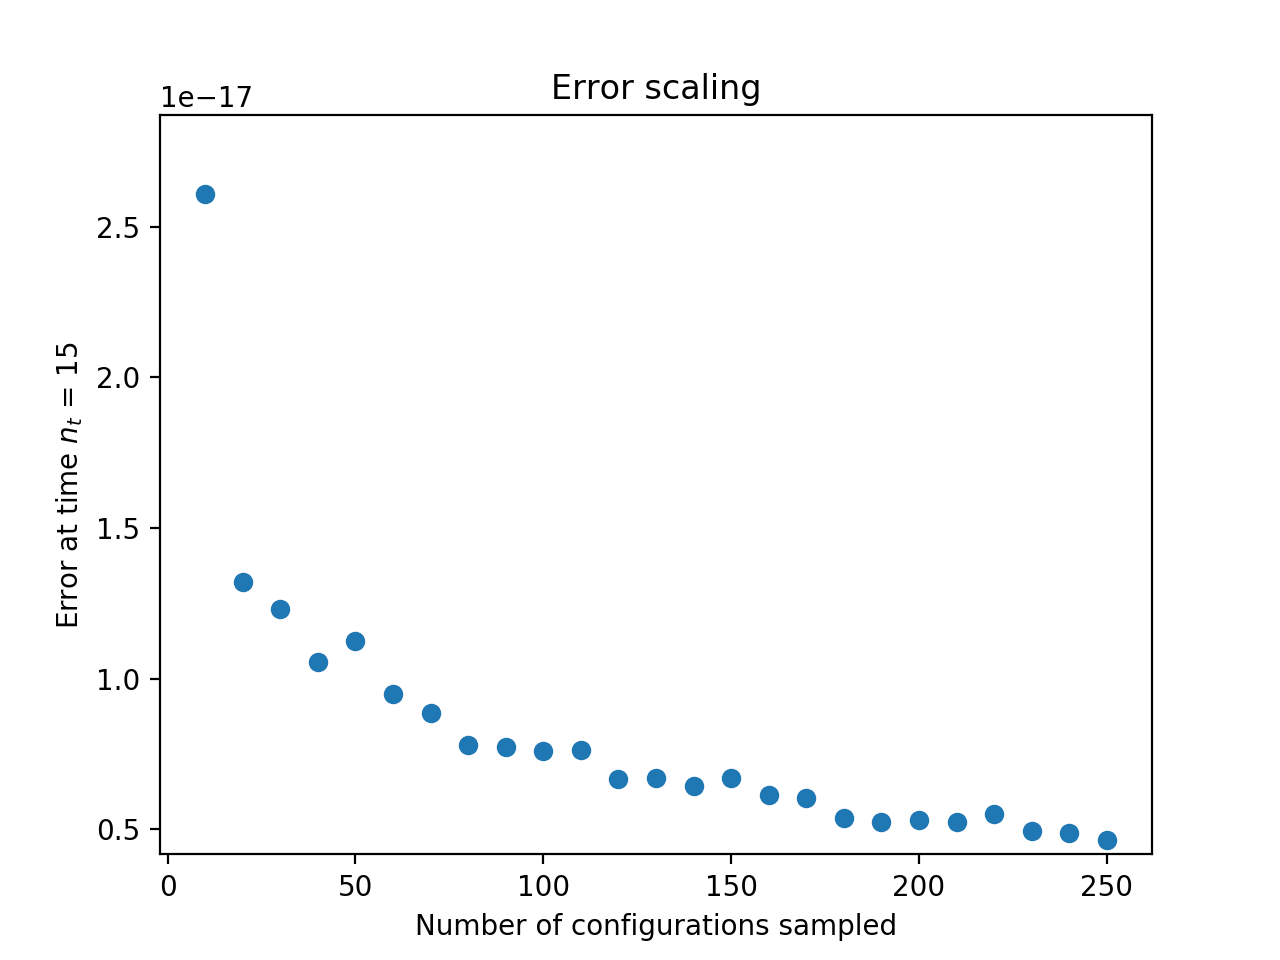

In [17]:
plt.figure()
plt.scatter(cfg_list, err)
plt.title('Error scaling')
plt.xlabel('Number of configurations sampled')
plt.ylabel('Error at time $n_t$ = ' + str(base_time))
# plt.ylim((1e-18, 1e-17))
plt.ylim((.9 * np.min(err), 1.1 * np.max(err)))
plt.show()